# Part III: An Unsupervised Feature Extractor:
## Restricted Boltzmann Machine

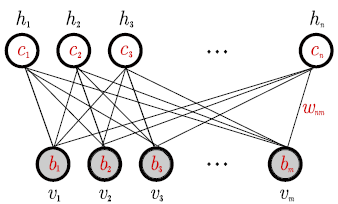

In [2]:
from IPython.display import Image
Image(filename = "rbm.png", width=444)

In [0]:
import tensorflow as tf
import numpy as np

class RBM:
    def __init__(self,
                 n_visible,
                 n_hidden,
                 learning_rate=0.01,
                 momentum=0.95,
                 xavier_const=1.0,
                 err_function='mse',
                 ):

        if err_function not in {'mse', 'cosine'}:
            raise ValueError('err_function should be either \'mse\' or \'cosine\'')


        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.momentum = momentum

        self.x = tf.placeholder(tf.float32, [None, self.n_visible])
        self.y = tf.placeholder(tf.float32, [None, self.n_hidden])

        self.w = tf.Variable(tf_xavier_init(self.n_visible, self.n_hidden, const=xavier_const), dtype=tf.float32)
        self.visible_bias = tf.Variable(tf.zeros([self.n_visible]), dtype=tf.float32)
        self.hidden_bias = tf.Variable(tf.zeros([self.n_hidden]), dtype=tf.float32)

        self.delta_w = tf.Variable(tf.zeros([self.n_visible, self.n_hidden]), dtype=tf.float32)
        self.delta_visible_bias = tf.Variable(tf.zeros([self.n_visible]), dtype=tf.float32)
        self.delta_hidden_bias = tf.Variable(tf.zeros([self.n_hidden]), dtype=tf.float32)

        self.update_weights = None
        self.update_deltas = None
        self.compute_hidden = None
        self.compute_visible = None
        self.compute_visible_from_hidden = None

        self._initialize_vars()


        if err_function == 'cosine':
            x1_norm = tf.nn.l2_normalize(self.x, 1)
            x2_norm = tf.nn.l2_normalize(self.compute_visible, 1)
            cos_val = tf.reduce_mean(tf.reduce_sum(tf.mul(x1_norm, x2_norm), 1))
            self.compute_err = tf.acos(cos_val) / tf.constant(np.pi)
        else:
            self.compute_err = tf.reduce_mean(tf.square(self.x - self.compute_visible))

        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)


    def get_err(self, batch_x):
        return self.sess.run(self.compute_err, feed_dict={self.x: batch_x})


    def reconstruct(self, batch_x):
        return self.sess.run(self.compute_visible, feed_dict={self.x: batch_x})

    def partial_fit(self, batch_x):
        self.sess.run(self.update_weights + self.update_deltas, feed_dict={self.x: batch_x})

    def fit(self,
            data_x,
            n_epoches=10,
            batch_size=10,
            shuffle=True,
            ):
        assert n_epoches > 0

        n_data = data_x.shape[0]

        if batch_size > 0:
            n_batches = n_data // batch_size + (0 if n_data % batch_size == 0 else 1)
        else:
            n_batches = 1

        if shuffle:
            data_x_cpy = data_x.copy()
            inds = np.arange(n_data)
        else:
            data_x_cpy = data_x

        errs = []

        for e in range(n_epoches):
            print('Epoch: {:d}'.format(e))

            epoch_errs = np.zeros((n_batches,))
            epoch_errs_ptr = 0

            if shuffle:
                np.random.shuffle(inds)
                data_x_cpy = data_x_cpy[inds]

            r_batches = range(n_batches)


            for b in r_batches:
                batch_x = data_x_cpy[b * batch_size:(b + 1) * batch_size]
                self.partial_fit(batch_x)
                batch_err = self.get_err(batch_x)
                epoch_errs[epoch_errs_ptr] = batch_err
                epoch_errs_ptr += 1

            err_mean = epoch_errs.mean()
            print('Train error: {:.4f}'.format(err_mean))
            print('')

            errs = np.hstack([errs, epoch_errs])

        return errs

    def get_weights(self):
        return self.sess.run(self.w),\
            self.sess.run(self.visible_bias),\
            self.sess.run(self.hidden_bias)

## Adding Noise for Real-world Data:

## Gaussian-Bernoulli Restricted Boltzmann Machine

### Helper Activation Functions

In [0]:
def tf_xavier_init(fan_in, fan_out, *, const=1.0, dtype=np.float32):
    k = const * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval=-k, maxval=k, dtype=dtype)

In [0]:
def sample_bernoulli(probs):
    return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

In [0]:
def sample_gaussian(x, sigma):
    return x + tf.random_normal(tf.shape(x), mean=0.0, stddev=sigma, dtype=tf.float32)

In [0]:
class GBRBM(RBM):
    def __init__(self, n_visible, n_hidden, sample_visible=False, sigma=1, **kwargs):
        self.sample_visible = sample_visible
        self.sigma = sigma

        RBM.__init__(self, n_visible, n_hidden, **kwargs)

    def _initialize_vars(self):
        hidden_p = tf.nn.sigmoid(tf.matmul(self.x, self.w) + self.hidden_bias)
        visible_recon_p = tf.matmul(sample_bernoulli(hidden_p), tf.transpose(self.w)) + self.visible_bias

        if self.sample_visible:
            visible_recon_p = sample_gaussian(visible_recon_p, self.sigma)

        hidden_recon_p = tf.nn.sigmoid(tf.matmul(visible_recon_p, self.w) + self.hidden_bias)

        positive_grad = tf.matmul(tf.transpose(self.x), hidden_p)
        negative_grad = tf.matmul(tf.transpose(visible_recon_p), hidden_recon_p)

        def f(x_old, x_new):
            return self.momentum * x_old +\
                   self.learning_rate * x_new * (1 - self.momentum) / tf.to_float(tf.shape(x_new)[0])

        delta_w_new = f(self.delta_w, positive_grad - negative_grad)
        delta_visible_bias_new = f(self.delta_visible_bias, tf.reduce_mean(self.x - visible_recon_p, 0))
        delta_hidden_bias_new = f(self.delta_hidden_bias, tf.reduce_mean(hidden_p - hidden_recon_p, 0))

        update_delta_w = self.delta_w.assign(delta_w_new)
        update_delta_visible_bias = self.delta_visible_bias.assign(delta_visible_bias_new)
        update_delta_hidden_bias = self.delta_hidden_bias.assign(delta_hidden_bias_new)

        update_w = self.w.assign(self.w + delta_w_new)
        update_visible_bias = self.visible_bias.assign(self.visible_bias + delta_visible_bias_new)
        update_hidden_bias = self.hidden_bias.assign(self.hidden_bias + delta_hidden_bias_new)

        self.update_deltas = [update_delta_w, update_delta_visible_bias, update_delta_hidden_bias]
        self.update_weights = [update_w, update_visible_bias, update_hidden_bias]

        self.compute_hidden = tf.nn.sigmoid(tf.matmul(self.x, self.w) + self.hidden_bias)
        self.compute_visible = tf.matmul(self.compute_hidden, tf.transpose(self.w)) + self.visible_bias
        self.compute_visible_from_hidden = tf.matmul(self.y, tf.transpose(self.w)) + self.visible_bias

#### The idea behind the model used in this presentation is obtained from the paper titled 
#### "Feature Extraction Using Restricted Boltzmann Machine for Stock Price Prediction"
#### written by Xianggao Cai, Su Hu, and Xiaola Lin from Sun Yat-sen University in Guangzhou, China.